In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
from numpy import math
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from imblearn.combine import SMOTEENN, SMOTETomek
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SCRIPTS DEL PROYECTO

## SCRIPT 1: Preparacion de datos para el entrenamiento

In [47]:
df_train=pd.read_csv(".\\data\\raw\\df_bank_train.csv")

In [48]:
df_train.y.value_counts()

no     31937
yes     4231
Name: y, dtype: int64

### Resultado Mutual Information -Feature Selection

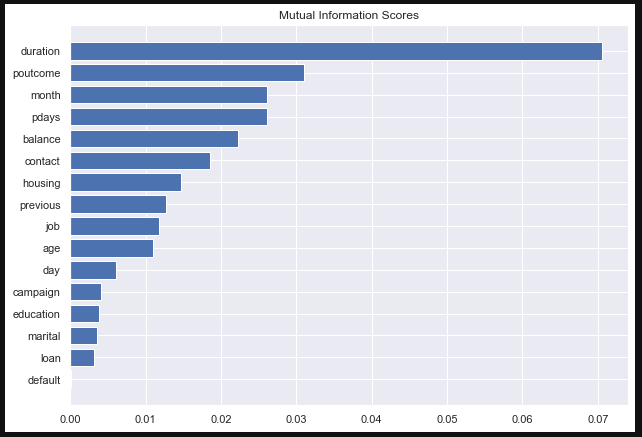

### Selección de variables inicial

In [49]:
to_drop = ['default','loan','marital','education','campaign','day','previous']
df_train.drop(columns=to_drop, axis=1, inplace = True)

### Pre-Procesamiento de datos

In [50]:
numeric_columns = set(df_train.select_dtypes(include=['number']).columns)
non_numeric_columns = set(df_train.columns) - numeric_columns
numeric_columns = list(numeric_columns)
non_numeric_columns= list(non_numeric_columns)
print(numeric_columns)
print(non_numeric_columns)

['balance', 'duration', 'age', 'pdays']
['job', 'contact', 'y', 'housing', 'poutcome', 'month']


#### Codificando columnas categoricas

In [51]:
for col in df_train.select_dtypes(['object']):
    df_train[col],unique = df_train[col].factorize(sort= True)

#### Tratamiento de Outliers

In [52]:
# funcion para calcular el limite superior e inferior de las variables numericas
def limites(columna):
    c = [.25,.75]
    q1,q3=columna.quantile(c)
    ## calculamos
    lim_inf = q3 - 1.5* (q3-q1)
    lim_sup = q3 + 1.5* (q3-q1)
    return(lim_inf ,lim_sup)

In [53]:
# Analizamos las variables numericas
for col in df_train[numeric_columns]:
    if col != 'pdays':
        a,b = limites(df_train[col])
        #recorte
        df_train.loc[df_train[col]<a,col] = a 
        df_train.loc[df_train[col]>b,col] = b 
    else:
        df_train[col]= df_train[col]

In [55]:
df_train["pdays"]= df_train["pdays"].replace([-1],0) # para no tener valores negativos, signfica que el cliente no fue contactado previamente

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])

### Balanceo de clases

In [62]:
X = df_train.drop('y',axis=1)
y = df_train['y']

In [64]:
SMT=SMOTEENN() 
x_bal, y_bal= SMT.fit_resample(X,y) 
from collections import Counter
print('Resampled dataset shape %s' % Counter(y_bal))

Resampled dataset shape Counter({1: 27736, 0: 25571})


In [65]:
df_train_proc=pd.concat([x_bal, y_bal], axis=1) 

In [67]:
df_train_proc.to_csv(".\\data\\processed\\df_bank_train_proc.csv", index = False)

## SCRIPT 2: Coddigo de  Entrenamiento

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Cargar la tabla transformada
df_train_proc = pd.read_csv(".\\data\\processed\\df_bank_train_proc.csv")
X_train = df_train_proc.drop(['y'],axis=1)
y_train = df_train_proc[['y']]

In [4]:
# Entrenamos el modelo con toda la muestra
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.05, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

xgb_model.fit(X_train, y_train)

[16:03:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.05, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [6]:
import pickle
# Guardamos el modelo entrenado para usarlo en produccion
filename = '.\\models\\best_model.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

## SCRIPT 3: Preparación de Datos de Validación

In [7]:
df_valid=pd.read_csv(".\\data\\raw\\df_bank_valid.csv")

In [8]:
# dropeo inicial por Feature selection- Mutual information
to_drop = ['default','loan','marital','education','campaign','day','previous']
df_valid.drop(columns=to_drop, axis=1, inplace = True)

In [9]:
numeric_columns = set(df_valid.select_dtypes(include=['number']).columns)
non_numeric_columns = set(df_valid.columns) - numeric_columns
numeric_columns = list(numeric_columns)
non_numeric_columns= list(non_numeric_columns)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'age', 'pdays', 'balance']
['contact', 'month', 'poutcome', 'housing', 'y', 'job']


In [11]:
# Codificando variables categoricas
for col in df_valid.select_dtypes(['object']):
    df_valid[col],unique = df_valid[col].factorize(sort= True)

In [13]:
# funcion para calcular el limite superior e inferior de las variables numericas
def limites(columna):
    c = [.25,.75]
    q1,q3=columna.quantile(c)
    ## calculamos
    lim_inf = q3 - 1.5* (q3-q1)
    lim_sup = q3 + 1.5* (q3-q1)
    return(lim_inf ,lim_sup)

In [14]:
# Analizamos las variables numericas
for col in df_valid[numeric_columns]:
    if col != 'pdays':
        a,b = limites(df_valid[col])
        #recorte
        df_valid.loc[df_valid[col]<a,col] = a 
        df_valid.loc[df_valid[col]>b,col] = b 
    else:
        df_valid[col]= df_valid[col]

In [15]:
df_valid["pdays"]= df_valid["pdays"].replace([-1],0) # para no tener valores negativos, signfica que el cliente no fue contactado previamente

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_valid[numeric_columns] = scaler.fit_transform(df_valid[numeric_columns])

In [19]:
df_valid.to_csv(".\\data\\processed\\df_bank_valid_proc.csv", index = False)

## SCRIPT 4: Código de Validación

In [22]:
import pandas as pd
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import *

In [24]:
# Cargar la tabla transformada
df_test = pd.read_csv(".\\data\\processed\\df_bank_valid_proc.csv")
X_test = df_test.drop(['y'],axis=1)
y_test = df_test[['y']]

In [25]:
# Leemos el modelo entrenado!
filename = '.\\models\\best_model.pkl'
model = pickle.load(open(filename, 'rb'))

In [27]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
y_pred_test=model.predict(X_test)

In [30]:
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test,y_pred_test))

[[2907 1085]
 [  29  500]]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      3992
           1       0.32      0.95      0.47       529

    accuracy                           0.75      4521
   macro avg       0.65      0.84      0.66      4521
weighted avg       0.91      0.75      0.80      4521



In [29]:
def save_plot(title):
    plt.title(title)
    fig = plt.gcf()
    filename = title.replace(" ", "_").lower()
    fig.savefig('{}'.format(filename), dpi=500)
    plt.clf()

In [31]:
plot_confusion_matrix(model, X_test, y_test)
save_plot('Confusion Matrix')

<Figure size 432x288 with 0 Axes>

In [32]:
plot_roc_curve(model, X_test, y_test)
save_plot('ROC Curve')

<Figure size 432x288 with 0 Axes>

## SCRIPT 5: Preparación de Datos de Score (Automatización)

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Cargar 
df_score = pd.read_csv(".\\data\\raw\\df_bank_score.csv")

In [3]:
# dropeo inicial por Feature selection- Mutual information
to_drop = ['default','loan','marital','education','campaign','day','previous']
df_score.drop(columns=to_drop, axis=1, inplace = True)

In [4]:
numeric_columns = set(df_score.select_dtypes(include=['number']).columns)
non_numeric_columns = set(df_score.columns) - numeric_columns
numeric_columns = list(numeric_columns)
non_numeric_columns= list(non_numeric_columns)
print(numeric_columns)
print(non_numeric_columns)

['balance', 'age', 'duration', 'pdays']
['housing', 'month', 'contact', 'job', 'poutcome']


In [5]:
# Codificando variables categoricas
for col in df_score.select_dtypes(['object']):
    df_score[col],unique = df_score[col].factorize(sort= True)

In [6]:
# funcion para calcular el limite superior e inferior de las variables numericas
def limites(columna):
    c = [.25,.75]
    q1,q3=columna.quantile(c)
    ## calculamos
    lim_inf = q3 - 1.5* (q3-q1)
    lim_sup = q3 + 1.5* (q3-q1)
    return(lim_inf ,lim_sup)

In [7]:
# Analizamos las variables numericas
for col in df_score[numeric_columns]:
    if col != 'pdays':
        a,b = limites(df_score[col])
        #recorte
        df_score.loc[df_score[col]<a,col] = a 
        df_score.loc[df_score[col]>b,col] = b 
    else:
        df_score[col]= df_score[col]

In [8]:
df_score["pdays"]= df_score["pdays"].replace([-1],0) # para no tener valores negativos, signfica que el cliente no fue contactado previamente

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_score[numeric_columns] = scaler.fit_transform(df_score[numeric_columns])

In [10]:
df_score.to_csv(".\\data\\processed\\df_bank_score_proc.csv", index = False)

## SCRIPT 6: Código de Scoring (Automatización)

In [12]:
import pandas as pd
import xgboost as xgb
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
# Cargar la tabla transformada
df_score = pd.read_csv(".\\data\\processed\\df_bank_score_proc.csv")

In [14]:
# Leemos el modelo entrenado!
filename = '.\\models\\best_model.pkl'
model = pickle.load(open(filename, 'rb'))

In [15]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
scores=model.predict(df_score).reshape(-1,1)

In [16]:
# Exportamos el resultado del modelo para cargarlo en el Feature Store o Data Mart de Modelos
# Le asignamos nombres a las columnas
df_scores = pd.DataFrame(scores, columns=['PREDICT'])
# Exportamos la solucion
df_scores.to_csv('.\\data\\scores\\final_score.csv')